In [38]:
import numpy as np
import pandas as pd
import re
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
import spacy
from spacy.lang.de.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
from wordcloud import WordCloud


#### Load the Dataset

In [39]:
ratings = pd.read_csv('raw_analyst_ratings.csv')

ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


#### First we will inspect the data and do minor cleaning as they are mostly clean

In [40]:
ratings.head()

Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00     A  
3  2020-05-22 12:45:06-04:00     A  
4  2020-05-22 11:38:59-04:00     A

In [41]:
ratings['paragraphs'] = ratings['headline'].map(lambda text: re.split('[.?!]\s*\n', text))
ratings['num_paragraphs'] = ratings['paragraphs'].map(len)

#### Once read the data is then vectorized and loaded into models

In [42]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
text_vectors = tfidf_vectorizer.fit_transform(ratings['headline'])
text_vectors.shape

(1407328, 108685)

In [43]:
para_df = pd.DataFrame([{'headline':paragraph, 'publisher':publisher}
                        for paragraphs, publisher in \
                            zip(ratings['paragraphs'], ratings['publisher'])
                            for paragraph in paragraphs if paragraph])

tfidf_p_vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
para_vectors = tfidf_p_vectorizer.fit_transform(para_df['headline'])
para_vectors.shape

(1407328, 108685)

In [44]:
nmf_mod = NMF(n_components=10, random_state=10)
weight_matrix = nmf_mod.fit_transform(text_vectors)
height_matrix = nmf_mod.components_

#### The models then show the output of the weighted words 

In [45]:
def display_topics(model, features, no_top_words=5):
    for topic, word_vector in enumerate(nmf_mod.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]
        print('\ntopic %02d' % topic)

        for i in range(0, no_top_words):
            print(' %s (%2.2f)' % (features[largest[i]],
                                   word_vector[largest[i]] * 100.0/total))

display_topics(nmf_mod, tfidf_vectorizer.get_feature_names_out())


topic 00
 moving (12.52)
 session (12.40)
 stocks (9.55)
 pre (8.09)
 market (5.43)

topic 01
 benzinga (18.20)
 top (17.26)
 upgrades (9.35)
 downgrades (9.15)
 initiations (3.01)

topic 02
 initiates (4.58)
 coverage (4.41)
 on (4.21)
 at (3.72)
 announces (3.57)

topic 03
 to (5.40)
 maintains (2.83)
 target (2.64)
 raises (2.61)
 price (2.50)

topic 04
 scheduled (9.37)
 for (9.14)
 earnings (9.09)
 february (2.15)
 2018 (1.92)

topic 05
 vs (5.80)
 est (5.73)
 eps (3.70)
 reports (2.93)
 sales (1.76)

topic 06
 movers (14.61)
 biggest (14.45)
 yesterday (10.94)
 from (10.59)
 friday (2.69)

topic 07
 the (3.74)
 of (1.95)
 trading (1.47)
 shares (1.38)
 are (1.31)

topic 08
 market (9.79)
 morning (8.19)
 losers (4.61)
 update (4.47)
 mid (4.03)

topic 09
 52 (10.75)
 week (10.54)
 stocks (8.46)
 hit (7.52)
 that (7.22)


In [46]:
weight_matrix.sum(axis=0)/weight_matrix.sum()*100.0

array([ 5.12563564,  9.07165369,  7.68000198, 10.78924976, 12.88323719,
       12.29892886,  7.29305099, 16.69307135,  9.0461278 ,  9.11904273])

In [47]:
nmf_p_mod = NMF(n_components=10, random_state=10)
weight_p_matrix = nmf_p_mod.fit_transform(para_vectors)
height_p_matrix = nmf_p_mod.components_

display_topics(nmf_p_mod, tfidf_p_vectorizer.get_feature_names_out())


topic 00
 moving (12.52)
 session (12.40)
 stocks (9.55)
 pre (8.09)
 market (5.43)

topic 01
 benzinga (18.20)
 top (17.26)
 upgrades (9.35)
 downgrades (9.15)
 initiations (3.01)

topic 02
 initiates (4.58)
 coverage (4.41)
 on (4.21)
 at (3.72)
 announces (3.57)

topic 03
 to (5.40)
 maintains (2.83)
 target (2.64)
 raises (2.61)
 price (2.50)

topic 04
 scheduled (9.37)
 for (9.14)
 earnings (9.09)
 february (2.15)
 2018 (1.92)

topic 05
 vs (5.80)
 est (5.73)
 eps (3.70)
 reports (2.93)
 sales (1.76)

topic 06
 movers (14.61)
 biggest (14.45)
 yesterday (10.94)
 from (10.59)
 friday (2.69)

topic 07
 the (3.74)
 of (1.95)
 trading (1.47)
 shares (1.38)
 are (1.31)

topic 08
 market (9.79)
 morning (8.19)
 losers (4.61)
 update (4.47)
 mid (4.03)

topic 09
 52 (10.75)
 week (10.54)
 stocks (8.46)
 hit (7.52)
 that (7.22)


In [48]:
svd_p_mod = TruncatedSVD(n_components=10, random_state=10)
weight_svd_mod = svd_p_mod.fit_transform(para_vectors)
height_svd_mod = svd_p_mod.components_

display_topics(svd_p_mod, tfidf_p_vectorizer.get_feature_names_out())


topic 00
 moving (12.52)
 session (12.40)
 stocks (9.55)
 pre (8.09)
 market (5.43)

topic 01
 benzinga (18.20)
 top (17.26)
 upgrades (9.35)
 downgrades (9.15)
 initiations (3.01)

topic 02
 initiates (4.58)
 coverage (4.41)
 on (4.21)
 at (3.72)
 announces (3.57)

topic 03
 to (5.40)
 maintains (2.83)
 target (2.64)
 raises (2.61)
 price (2.50)

topic 04
 scheduled (9.37)
 for (9.14)
 earnings (9.09)
 february (2.15)
 2018 (1.92)

topic 05
 vs (5.80)
 est (5.73)
 eps (3.70)
 reports (2.93)
 sales (1.76)

topic 06
 movers (14.61)
 biggest (14.45)
 yesterday (10.94)
 from (10.59)
 friday (2.69)

topic 07
 the (3.74)
 of (1.95)
 trading (1.47)
 shares (1.38)
 are (1.31)

topic 08
 market (9.79)
 morning (8.19)
 losers (4.61)
 update (4.47)
 mid (4.03)

topic 09
 52 (10.75)
 week (10.54)
 stocks (8.46)
 hit (7.52)
 that (7.22)


In [49]:
count_p_vectorizer = CountVectorizer(stop_words=list(STOP_WORDS))
count_p_vectors = count_p_vectorizer.fit_transform(para_df['headline'])

lda_mod = LatentDirichletAllocation(n_components=10, random_state=10)
weight_lda_matrix = lda_mod.fit_transform(count_p_vectors)
height_lda_matrix = lda_mod.components_

display_topics(lda_mod, tfidf_p_vectorizer.get_feature_names_out())


topic 00
 moving (12.52)
 session (12.40)
 stocks (9.55)
 pre (8.09)
 market (5.43)

topic 01
 benzinga (18.20)
 top (17.26)
 upgrades (9.35)
 downgrades (9.15)
 initiations (3.01)

topic 02
 initiates (4.58)
 coverage (4.41)
 on (4.21)
 at (3.72)
 announces (3.57)

topic 03
 to (5.40)
 maintains (2.83)
 target (2.64)
 raises (2.61)
 price (2.50)

topic 04
 scheduled (9.37)
 for (9.14)
 earnings (9.09)
 february (2.15)
 2018 (1.92)

topic 05
 vs (5.80)
 est (5.73)
 eps (3.70)
 reports (2.93)
 sales (1.76)

topic 06
 movers (14.61)
 biggest (14.45)
 yesterday (10.94)
 from (10.59)
 friday (2.69)

topic 07
 the (3.74)
 of (1.95)
 trading (1.47)
 shares (1.38)
 are (1.31)

topic 08
 market (9.79)
 morning (8.19)
 losers (4.61)
 update (4.47)
 mid (4.03)

topic 09
 52 (10.75)
 week (10.54)
 stocks (8.46)
 hit (7.52)
 that (7.22)


#### After multiple different learning techniques we see they are similar in output so we will load them insto a visualization for easy consumpiton

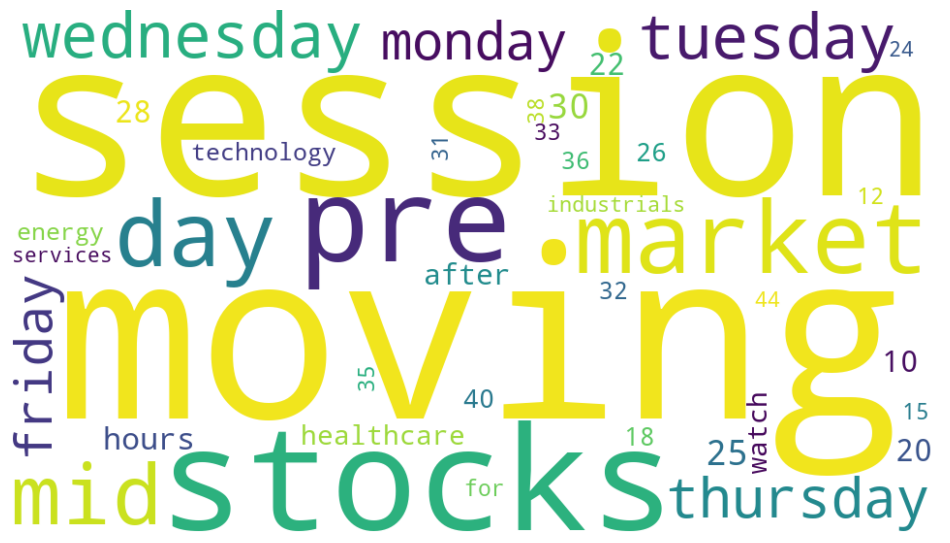

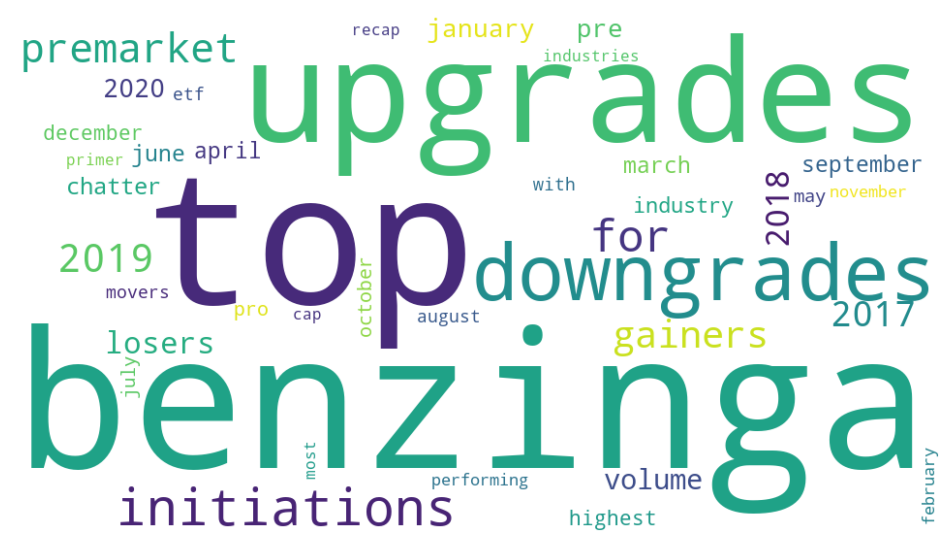

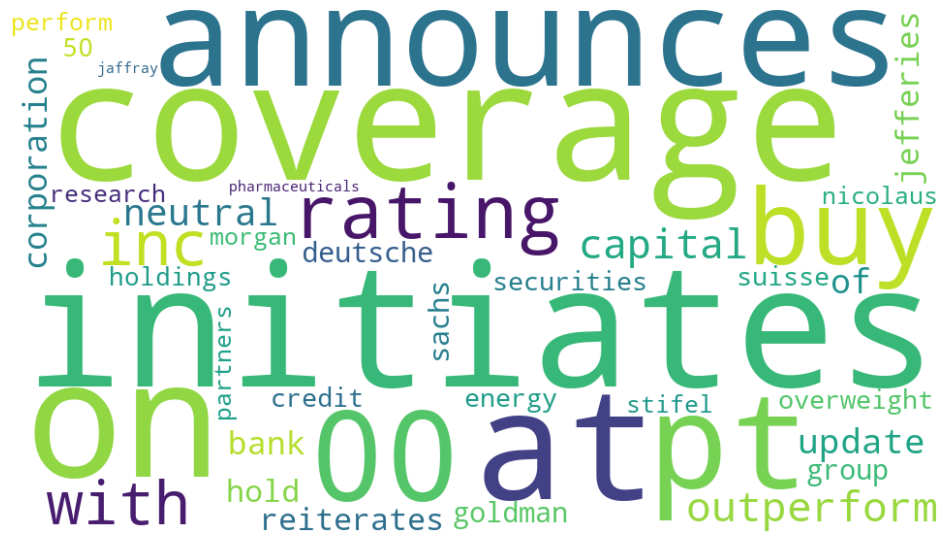

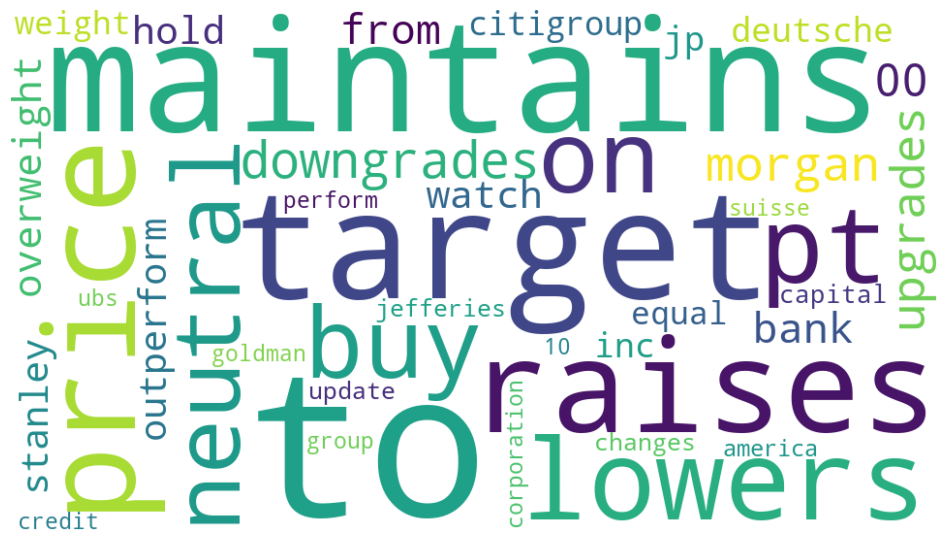

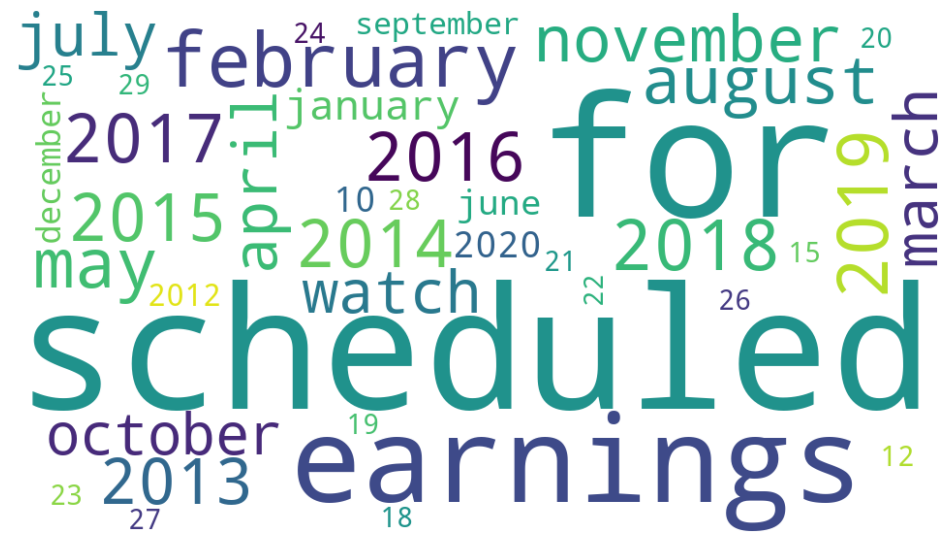

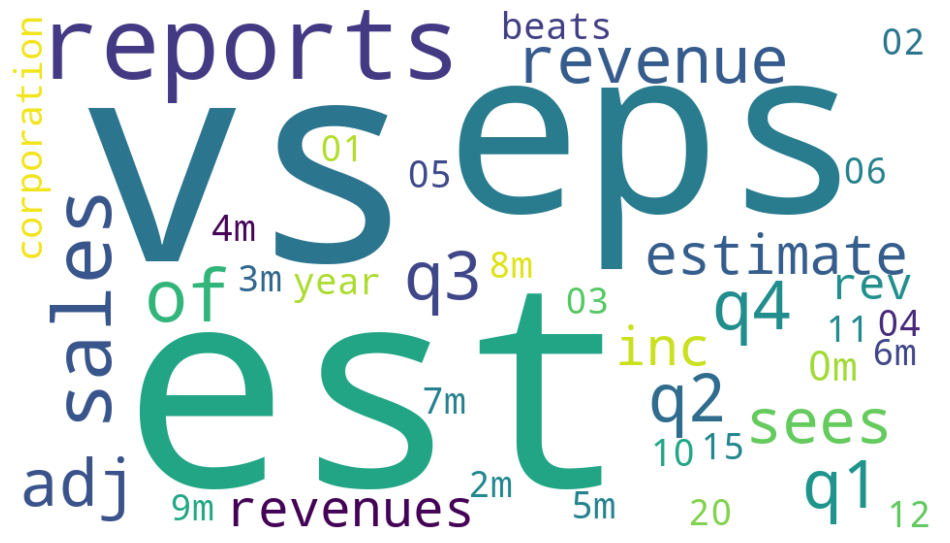

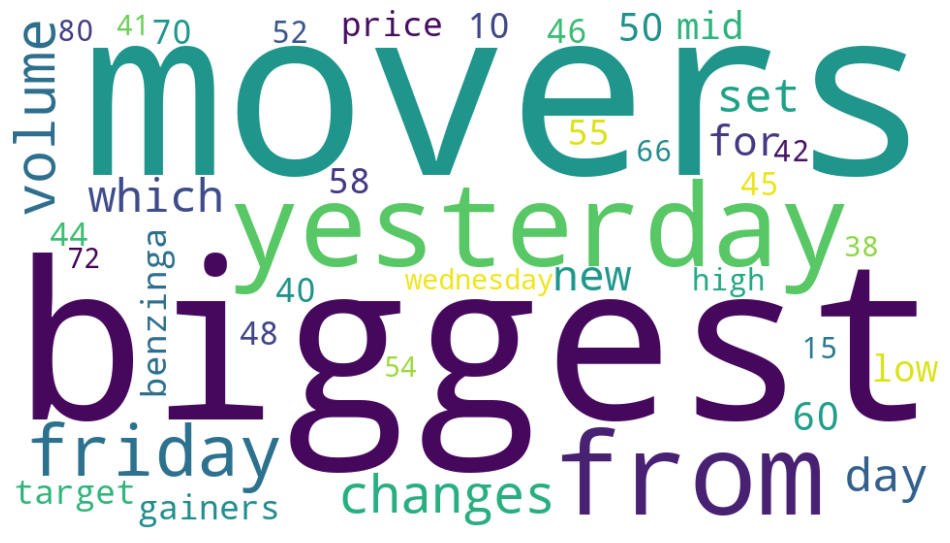

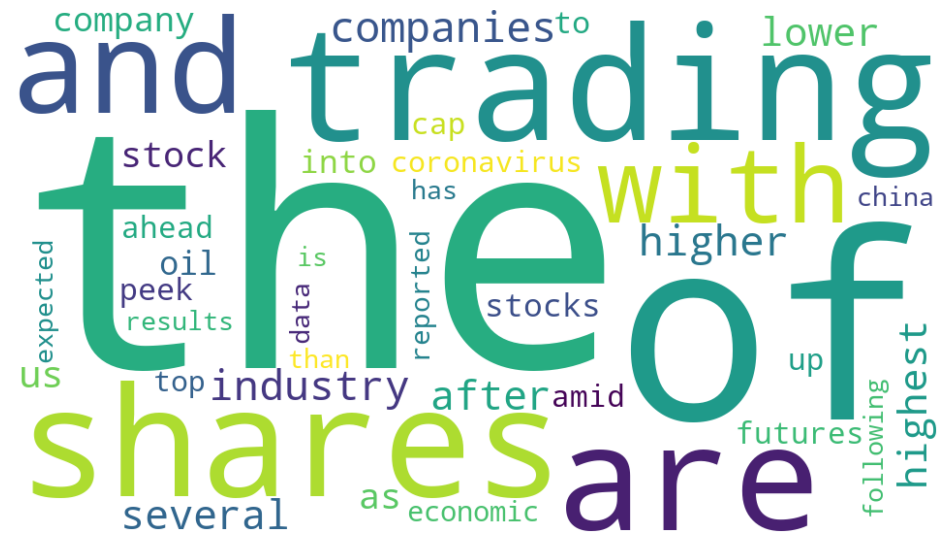

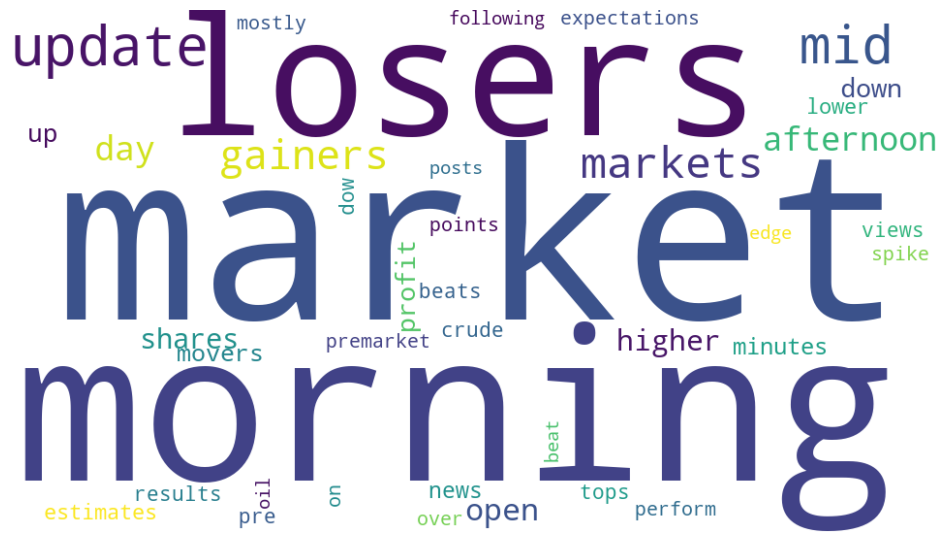

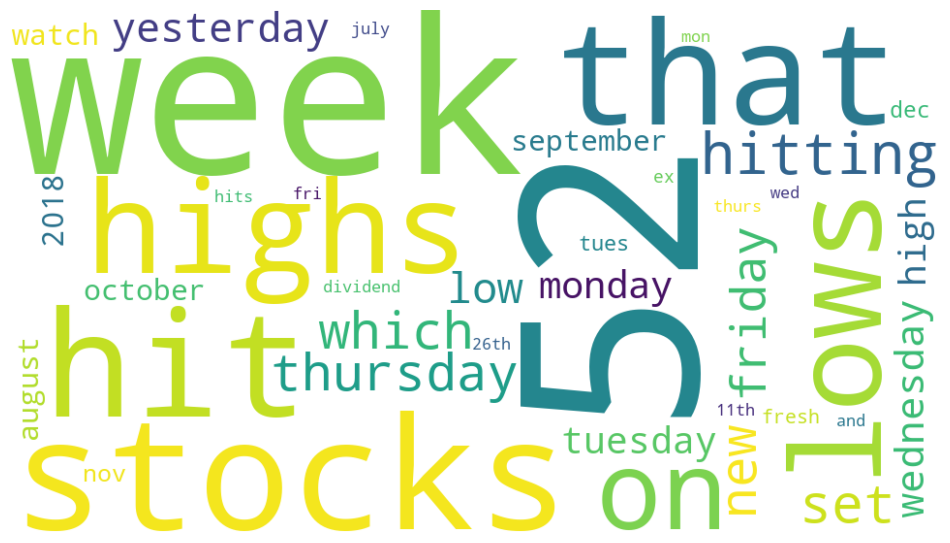

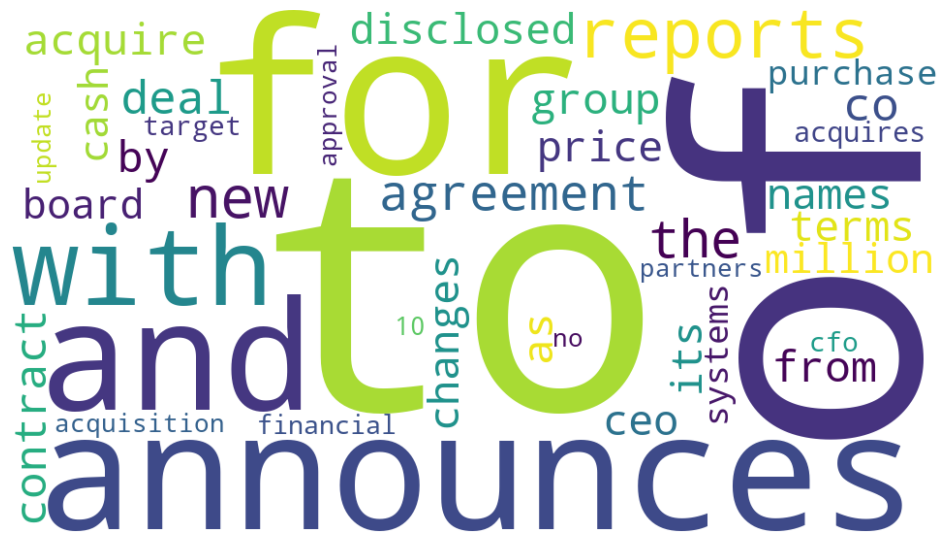

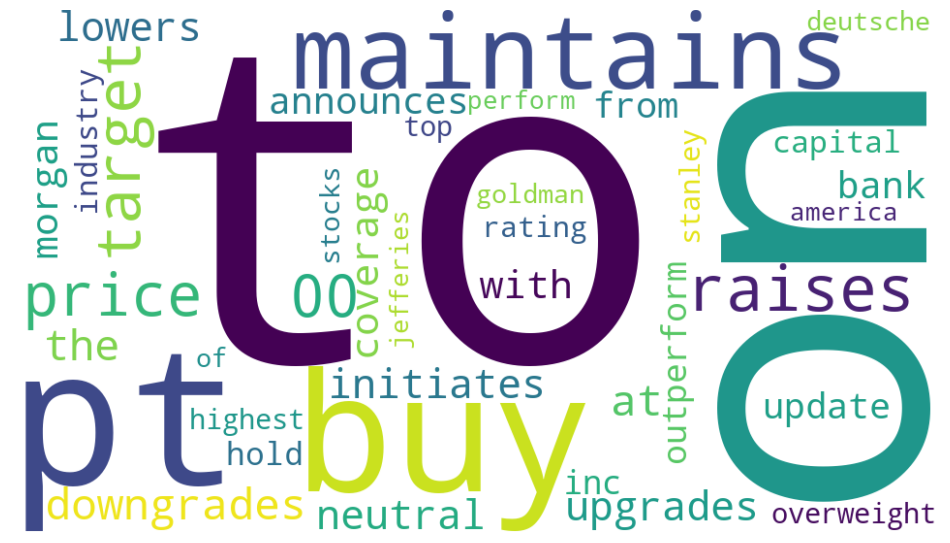

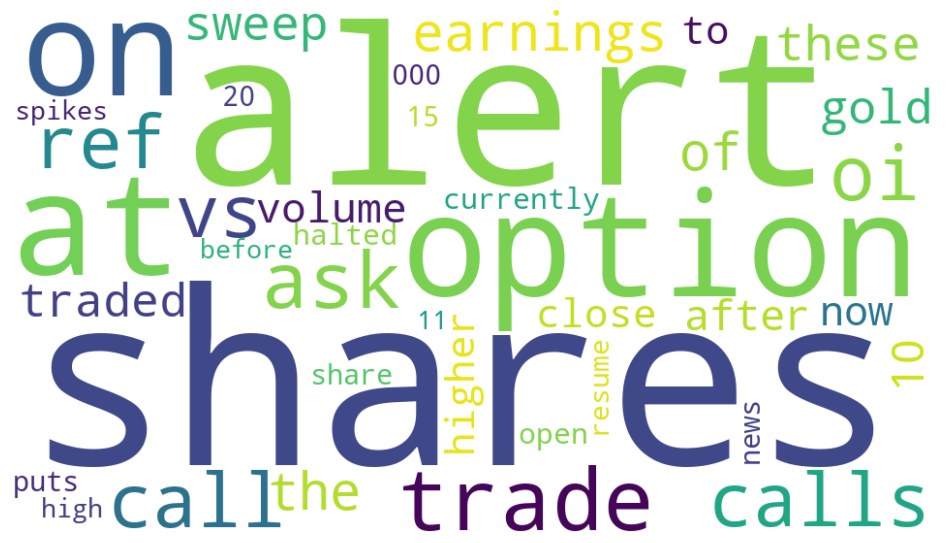

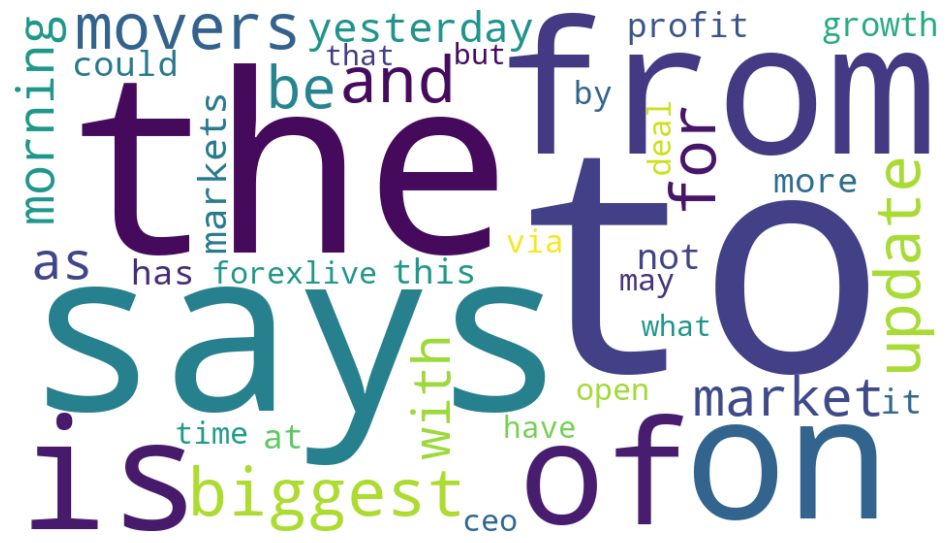

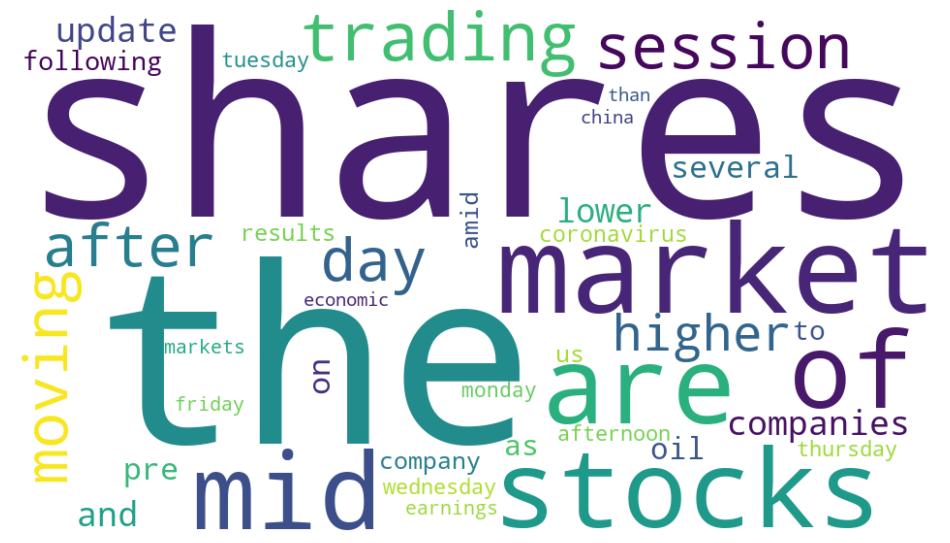

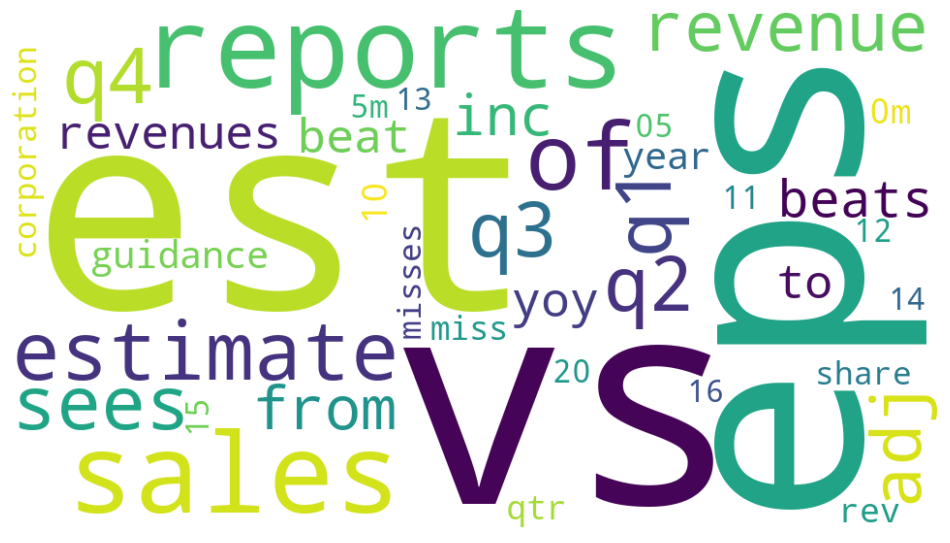

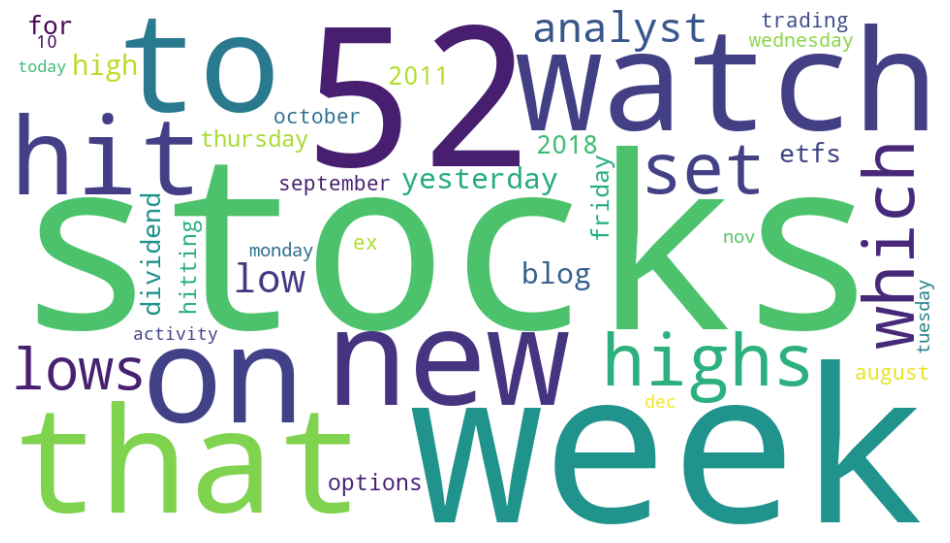

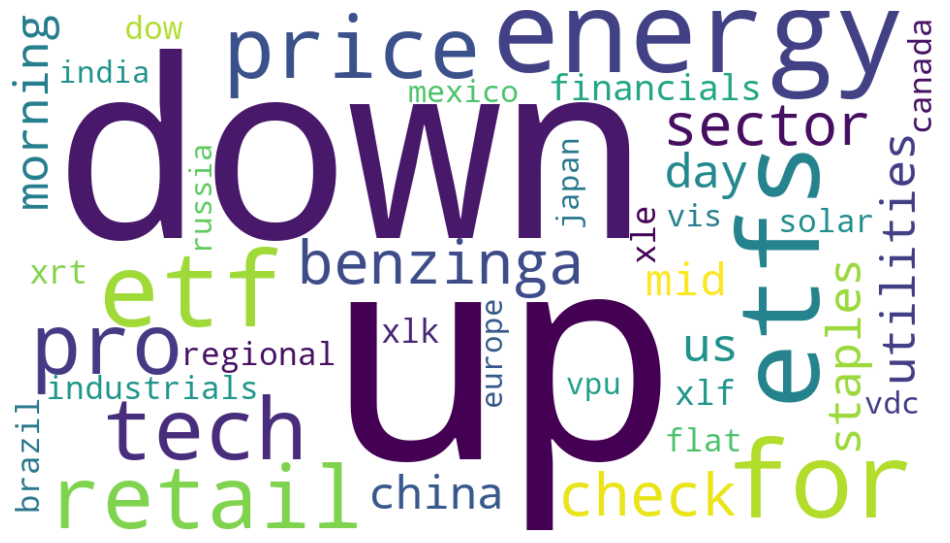

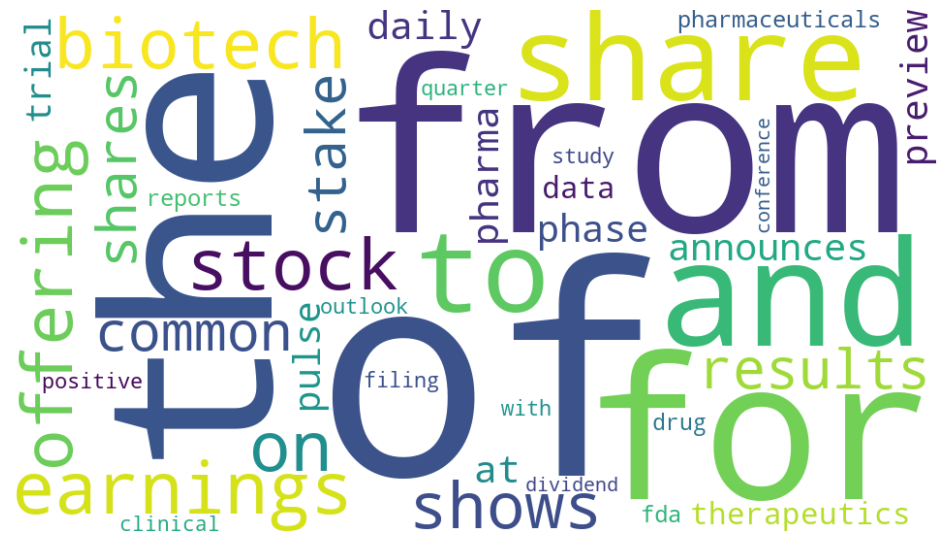

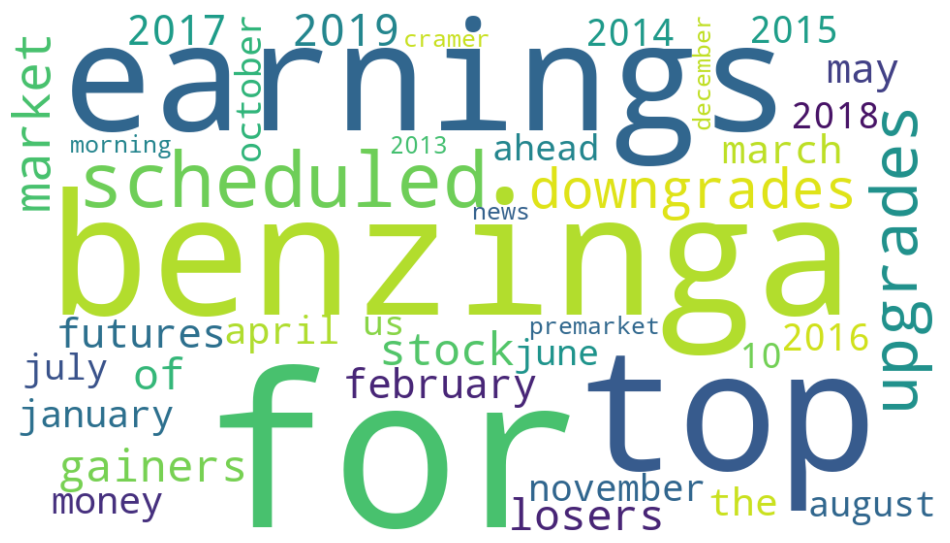

In [50]:
def wordcloud_topics (model, features, no_top_words = 40):
    for topic, words in enumerate (model.components_):
        size = {}
        largest = words.argsort ()[::-1]  # invert sort order
        for i in range (0, no_top_words):
            size [features [largest [i]]] = abs (words [largest [i]])
        wc = WordCloud (background_color = "white", max_words = 100,
                       width = 960, height = 540)
        wc.generate_from_frequencies (size)
        plt.figure (figsize = (12, 12))
        plt.imshow (wc, interpolation = 'bilinear')
        plt.axis ('off')
        
# compare NMF and LDA model
wordcloud_topics (nmf_p_mod, tfidf_p_vectorizer.get_feature_names_out())
wordcloud_topics (lda_mod, count_p_vectorizer.get_feature_names_out ())

#### In conclusion we can see based on these word clouds the system goes throught the given sentences and rates the words, finding the most weighted ones and displaying them. The different forms of learning, in this case a quite similar in output.